# Derive combined map Turbine-Nozzle

![turbojet_scheme.png](turbojet_scheme.png)

Retrieve Turbine data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
from IPython.display import clear_output

from utils_plot_iso_T3T1 import p_over_pt_from_M, mass_flow_per_area_from_M, M_from_p_over_pt
import os

In [2]:
def read_table(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
    col_vals = df.iloc[0,1:].values
    row_vals = df.iloc[1:,0].values
    central_vals = df.iloc[1:,1:].values
    return col_vals, row_vals, central_vals

In [3]:
folder = "turbine_map"

# -----------------------------
# Read turbine mass flow
# -----------------------------
beta_turb, speed_turb, mf_vals_turb = read_table(f"{folder}/formatted_mass_flow.txt")
_, _, iso_eff_turb = read_table(f"{folder}/formatted_iso_efficiency.txt")

# Pressure ratio mapping (simple linear scaling, see cell below)
PR_turb_min, PR_turb_max = 0.01, 3.8
PR_turb = np.linspace(PR_turb_min, PR_turb_max, len(beta_turb))

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_18856\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_18856\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style


In [4]:
# The four parameters characterizing the Turbine working point are stored in:
# PR_turb (shape: (9, )), speed_turb (shape: (9, )), mf_vals_turb (shape: (9, 9)), iso_eff_turb (shape: (9, 9))
# => to fix a point we need to fix two of these: we want them to be PR_turb (already a vector) and mf_vals_turb (to be converted)

n_rows, n_cols = mf_vals_turb.shape  # rows = speed, cols = PR

# Crea griglie di PR e N corrispondenti alla matrice originale
PR_turb_grid, N_grid = np.meshgrid(PR_turb, speed_turb)

# Flatten coerente
mf_flat_turb = mf_vals_turb.flatten()
pr_flat_turb = PR_turb_grid.flatten()
speed_flat_turb = N_grid.flatten()
eff_flat_turb = iso_eff_turb.flatten()

num_steps = 200

mf_turb_grid, pr_turb_grid = np.meshgrid(
    np.linspace(mf_flat_turb.min(), mf_flat_turb.max(), num_steps),
    np.linspace(pr_flat_turb.min(), pr_flat_turb.max(), num_steps)
)

# Now we have two flattened arrays, in mf_values we have all the values of corrected mass flow, 
# in PR_vs_speed_tuples we have, in tuples, the coordinates of each element in mf_values


# Now we want to interpolate
eff_turb_grid = griddata((mf_flat_turb, pr_flat_turb), eff_flat_turb, (mf_turb_grid, pr_turb_grid), method='cubic')
speed_turb_grid = griddata((mf_flat_turb, pr_flat_turb), speed_flat_turb, (mf_turb_grid, pr_turb_grid), method='cubic')

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_18856\698038457.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm1 = axes[0].pcolormesh(PR_turb_grid, mf_vals_turb, iso_eff_turb, shading='auto', cmap='viridis')
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_18856\698038457.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm2 = axes[1].pcolormesh(PR_turb_grid, mf_vals_turb, N_grid, shading='auto', cmap='plasma')


Text(0.5, 1.0, 'Turbine Speed (original grid)')

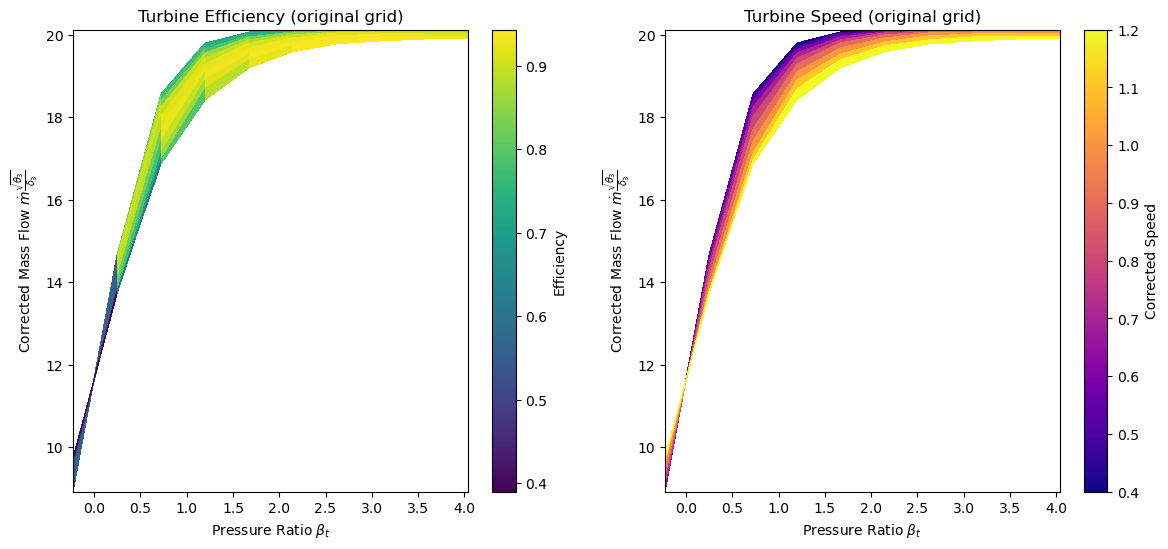

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))  # 1 riga, 2 colonne

# --- Efficiency ---
pcm1 = axes[0].pcolormesh(PR_turb_grid, mf_vals_turb, iso_eff_turb, shading='auto', cmap='viridis')
fig.colorbar(pcm1, ax=axes[0], label='Efficiency')
axes[0].set_xlabel(r'Pressure Ratio $\beta_t$')
axes[0].set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$')
axes[0].set_title('Turbine Efficiency (original grid)')

# --- Spool speed N ---
pcm2 = axes[1].pcolormesh(PR_turb_grid, mf_vals_turb, N_grid, shading='auto', cmap='plasma')
fig.colorbar(pcm2, ax=axes[1], label='Corrected Speed')
axes[1].set_xlabel(r'Pressure Ratio $\beta_t$')
axes[1].set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$')
axes[1].set_title('Turbine Speed (original grid)')


# Nozzle map calculation

In [6]:
# ============================================================
# DATI NOZZLE
# ============================================================
A_out = 0.3 ** 2 * np.pi     # [m^2]
A_in = 0.45 ** 2 * np.pi

gamma = 1.33    # [-]
R = 287.0      # [J / kg / K]
p_amb = 101325 # [Pa]

# Tt1 = T_amb
# Tt2 = Tt1 * ( 1 + (beta_comp ** ((gamma - 1) / (gamma)) - 1) / eta_comp)
# Tt3 = calculate_T3_tot(Tt2, alpha = alpha0, max_iter = 5, tol = 1e-4)
# Tt4 = Tt3 * ( 1 - eta_turb * ( 1 - PR_turb ** (- (gamma - 1)/(gamma)) ) )
Tt4 = 800

T_ref = 288

PR_nozzle_vals = np.linspace(1, 5, 10000)
pt_vals = PR_nozzle_vals * p_amb
mf_vals_nozz = np.zeros_like(PR_nozzle_vals)

p_over_pt_crit = p_over_pt_from_M(1, gamma)
PR_nozzle_crit = 1.0 / p_over_pt_crit

for i, pt_i in enumerate(pt_vals):
    p_ratio = p_amb / pt_i
    if p_ratio < p_over_pt_crit: # Careful! It's p_over_pt ~ 0.5 not pt_over_p ~ 1.85 
        M_exit = 1.0
        mass_flow_area, _ = mass_flow_per_area_from_M(pt_i, Tt4, M_exit, gamma, R)
        mf_vals_nozz[i] = A_out * mass_flow_area * np.sqrt(Tt4/T_ref) / (pt_i / p_amb)
    else:
        M_root = M_from_p_over_pt(p_ratio, gamma)
        mass_flow_area, _ = mass_flow_per_area_from_M(pt_i, Tt4, M_root, gamma, R)
        mf_vals_nozz[i] = A_out * mass_flow_area *  np.sqrt(Tt4/T_ref) / (pt_i / p_amb)

[ 0.          2.81743372  3.98275851 ... 67.02657185 67.02657185
 67.02657185]


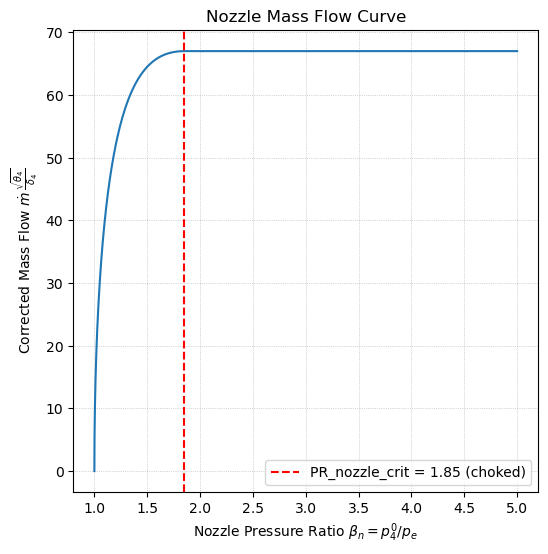

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

# --- Nozzle Curve ---
axes.plot(PR_nozzle_vals, mf_vals_nozz, color='tab:blue')
axes.axvline(PR_nozzle_crit, linestyle='--', color='red',
                label=f'PR_nozzle_crit = {PR_nozzle_crit:.2f} (choked)')
axes.set_xlabel(r'Nozzle Pressure Ratio $\beta_n = p_4^0 / p_e$')
axes.set_ylabel(r'Corrected Mass Flow $\dot{m} \, \frac{\sqrt{\theta_4}}{\delta_4}$')
axes.set_title('Nozzle Mass Flow Curve')
axes.grid(True, linestyle=':', linewidth=0.5)
axes.legend()

print(mf_vals_nozz)

## Conversion of the nozzle map

In [8]:
# The four parameters characterizing the Turbine working point are stored in:
# PR_turb (shape: (9, )), speed_turb (shape: (9, )), mf_vals_turb (shape: (9, 9)), iso_eff_turb (shape: (9, 9))

# The parameters characterizing the Nozzle working point are stored in:
# PR_nozzle_vals (shape: (100, )), mf_vals_nozz (shape: (100, ))

# We want an output like:
# PR_turb_nozz (shape: (9, 9)), mf_turb_nozz (shape: (9, 9)), corrected with pre-Turbine quantities, speed_grid (shape: (9, 9), but is actually the same col repeated across the rows)

mf_crit_nozz = mf_vals_nozz[-1]

PR_turb_nozz = np.zeros_like(mf_vals_turb)
mf_turb_nozz = np.zeros_like(mf_vals_turb)

for i, PRt in enumerate(PR_turb):
    for j, Nt in enumerate(speed_turb):

        # Set a point on the Turbine map (PRt and Nt are already selected by the for cycles):
        mf_turb = mf_vals_turb[j, i] # the correct indexing is mf_vals_turb[PR_idx, N_idx]
        eta_turb = iso_eff_turb[j, i]

        # Calculate the corrected mass flow that would go through the nozzle
        mf_nozzle = mf_turb * PRt * np.sqrt(( 1 - eta_turb * ( 1 - PRt ** ( - (gamma - 1)/(gamma) ) ) ) )
        if mf_nozzle <= mf_crit_nozz:
            # then the selected point is fine, the turbine is not blocked

            # The overall PR is the product between the two
            idx_PRn = np.abs(mf_vals_nozz - mf_nozzle).argmin()
            PR_turb_nozz[j, i] = PRt * PR_nozzle_vals[idx_PRn]

            # The mass flowing is corrected  with pre-turbine params
            mf_turb_nozz[j, i] = mf_turb

        elif np.isclose(mf_nozzle, mf_crit_nozz, rtol = 0.05, atol = 2): 
            # The nozzle is choked, the turbine is blocked: the maximum mass flow is the one allowed by the nozzle, corrected with pre-turbine quantities by convention
            mf_turb_nozz[j, i] = mf_crit_nozz / PRt / np.sqrt(( 1 - eta_turb * ( 1 - PRt ** ( - (gamma - 1)/(gamma) ) ) ) )
            # Now the Nozzle has an increase in PR without letting more mass to flow
            idx_PRn = np.abs(mf_vals_nozz - mf_nozzle).argmin() 
            PR_turb_nozz[j, i] = PRt * PR_nozzle_vals[idx_PRn]
        
        else:
            mf_turb_nozz[j, i] = np.nan
            PR_turb_nozz[j, i] = np.nan

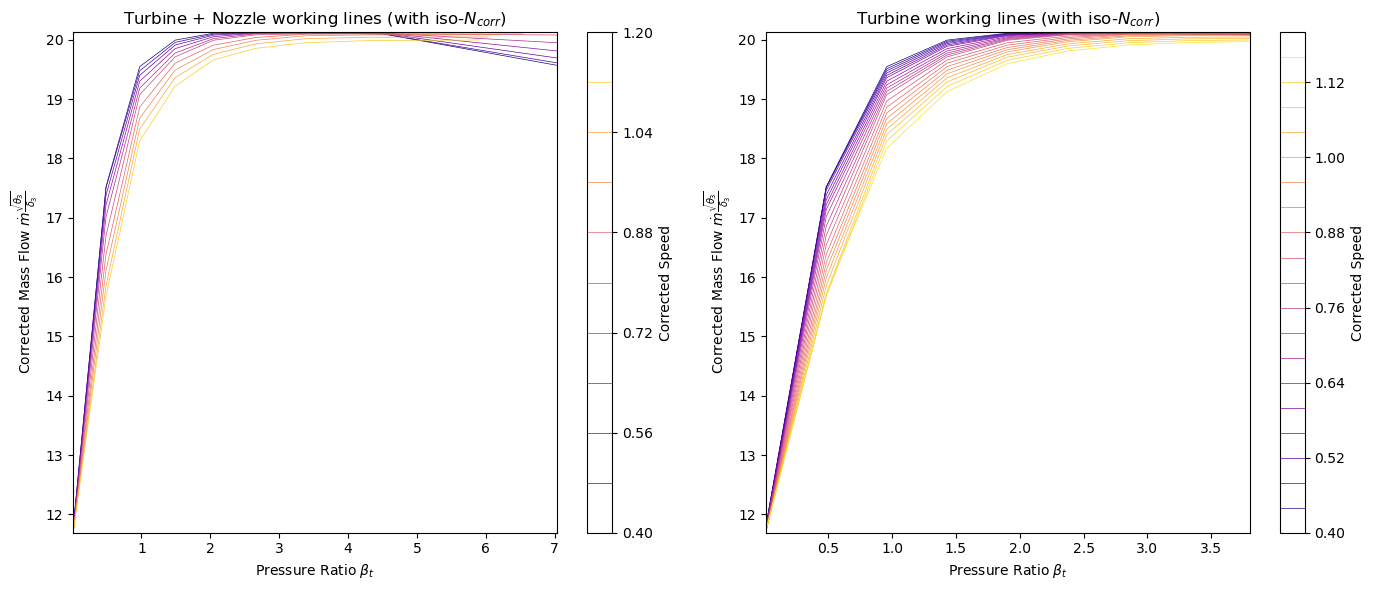

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6) )  # 1 row, 2 columns

# --- Efficiency (Contour) ---
lines1 = axes[0].contour(PR_turb_nozz, mf_turb_nozz, N_grid, levels=10, cmap = 'plasma', linewidths=0.5)
cbar1 = fig.colorbar(lines1 , ax=axes[0], label='Corrected Speed')
axes[0].set_xlabel(r'Pressure Ratio $\beta_t$')
axes[0].set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$')
axes[0].set_title(r'Turbine + Nozzle working lines (with iso-$N_{corr}$)')

# --- Spool speed N (Contour) ---
lines2 = axes[1].contour(PR_turb_grid, mf_vals_turb, N_grid, levels=20,  cmap = 'plasma', linewidths=0.5)
cbar2 = fig.colorbar(lines2 , ax=axes[1], label='Corrected Speed')
axes[1].set_xlabel(r'Pressure Ratio $\beta_t$')
axes[1].set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$')
axes[1].set_title(r'Turbine working lines (with iso-$N_{corr}$)')

# Optional contour lines

plt.tight_layout()
plt.show()